In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
# read in 13F data
file_name = '/content/gdrive/My Drive/capstone/full database/Results_20160630_20200630.csv'
df = pd.read_csv(file_name)

In [4]:
# read in list of investors of interest
ls_investors = pd.read_csv('/content/gdrive/My Drive/capstone/full database/ListOfInvestor.csv').LgcyInvestorID.to_list()
len(ls_investors)

229

## Calculate 13F-only Portfolio Holding Pct

In [5]:
df_sub = df.loc[df['LGCYINVESTORID'].isin(ls_investors),['INSTRID', 'COMNAME', 'LGCYINVESTORID', 'FULLNAME', 'HOLDDATE', 'SHSHLDVAL']]

# calculate the sum of SHSHLDVAL for each investor in each quarter
df_sub['SHSHLDVAL_Sum_ByQuarter'] = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).transform('sum').drop(['INSTRID', 'FULLNAME'], axis = 1)

# calculate the (13F only) pct of the SHSHLDVAL of each instrument in its investor's sum of SHSHLDVAL for each quarter 
# (i.e. revised version of 'PCTPORTFOLIO', so that sum up to 1)
df_sub['PCTPORTFOLIO_13F'] = df_sub['SHSHLDVAL'] / df_sub['SHSHLDVAL_Sum_ByQuarter']

# save to drive
# with open('/content/gdrive/My Drive/capstone/full database/portfolio_13F.csv', 'w') as f:
#   df_sub.to_csv(f)

## Concatenate Investor ID and Holddate

In [6]:
df_sub["LGCYINVESTORID"] = df_sub["LGCYINVESTORID"].astype(str)
df_sub["INSTRID"] = df_sub["INSTRID"].astype(str)
df_sub['HOLDDATE'] = df_sub['HOLDDATE'].str.replace(r' 00:00:00', '')
df_sub['LGCYINVESTORID_HOLDDATE'] =  df_sub[['LGCYINVESTORID', 'HOLDDATE']].apply(lambda x: '_'.join(x), axis=1)
df_sub.head()

,INSTRID,COMNAME,LGCYINVESTORID,FULLNAME,HOLDDATE,SHSHLDVAL,SHSHLDVAL_Sum_ByQuarter,PCTPORTFOLIO_13F,LGCYINVESTORID_HOLDDATE
0,8589934603,First Trust Consumer Discretionary AlphaDEX ETF,2003020,BofA Global Research (US),2020-06-30,15119117.23,3.439259e+11,0.000044,2003020_2020-06-30
8,8589934603,First Trust Consumer Discretionary AlphaDEX ETF,2003020,BofA Global Research (US),2017-06-30,12815061.00,2.976255e+11,0.000043,2003020_2017-06-30
16,8589934603,First Trust Consumer Discretionary AlphaDEX ETF,2003020,BofA Global Research (US),2017-12-31,14477360.58,3.230778e+11,0.000045,2003020_2017-12-31
24,8589934603,First Trust Consumer Discretionary AlphaDEX ETF,2003020,BofA Global Research (US),2018-03-31,12468032.28,3.066132e+11,0.000041,2003020_2018-03-31
32,8589934603,First Trust Consumer Discretionary AlphaDEX ETF,2003020,BofA Global Research (US),2017-03-31,16205549.78,2.879759e+11,0.000056,2003020_2017-03-31


## Check the missing records

In [ ]:
print(len(set(df_sub.LGCYINVESTORID))*len(set(df_sub.HOLDDATE)))
print(len(set(df_sub.LGCYINVESTORID_HOLDDATE)))
for investor in set(df_sub.LGCYINVESTORID):
  if len(set((df_sub.loc[df_sub['LGCYINVESTORID']==investor,'HOLDDATE'].to_list()))) < len(set(df_sub.HOLDDATE)):
    print('Investor ID:', investor, ' missing:')
    print(set(df_sub.HOLDDATE) - set(df_sub.loc[df_sub['LGCYINVESTORID']==investor,'HOLDDATE'].to_list()))
    

3893
3689
Investor ID: 10233291  missing:
{'2017-12-31', '2016-09-30', '2017-03-31', '2016-12-31', '2018-12-31', '2019-06-30', '2016-06-30', '2018-06-30', '2017-06-30', '2019-03-31', '2018-03-31', '2017-09-30', '2019-09-30', '2018-09-30'}
Investor ID: 2003597  missing:
{'2017-12-31', '2016-09-30', '2016-06-30', '2018-06-30', '2017-06-30', '2018-03-31', '2017-03-31', '2017-09-30', '2016-12-31', '2018-09-30'}
Investor ID: 2420555  missing:
{'2016-09-30', '2016-06-30'}
Investor ID: 10235680  missing:
{'2017-12-31', '2016-09-30', '2017-03-31', '2016-12-31', '2018-12-31', '2019-06-30', '2016-06-30', '2018-06-30', '2017-06-30', '2019-03-31', '2018-03-31', '2017-09-30', '2019-09-30', '2018-09-30'}
Investor ID: 6139212  missing:
{'2019-06-30', '2019-03-31', '2019-09-30', '2019-12-31', '2020-06-30'}
Investor ID: 2275507  missing:
{'2016-09-30', '2016-06-30', '2017-06-30', '2017-03-31', '2017-09-30', '2016-12-31'}
Investor ID: 5200477  missing:
{'2017-12-31', '2016-09-30', '2016-06-30', '2018-06

## Pivot table with Invester_Holddate as rows, Instruments as columns

In [7]:
inves_instr_pivot = pd.pivot_table(df_sub,index = ['LGCYINVESTORID_HOLDDATE'], columns = ['INSTRID'],values=['PCTPORTFOLIO_13F']).fillna(0)
inves_instr_pivot.columns = inves_instr_pivot.columns.droplevel()
# with open('/content/gdrive/My Drive/capstone/full database/inves_instr_pivot.csv', 'w') as f:
#    inves_instr_pivot.to_csv(f)


In [8]:
print(inves_instr_pivot.sum(axis=1)) # all row sums should be 1
print(inves_instr_pivot.shape)

LGCYINVESTORID_HOLDDATE
10061989_2016-06-30    1.0
10061989_2016-09-30    1.0
10061989_2016-12-31    1.0
10061989_2017-03-31    1.0
10061989_2017-06-30    1.0
                      ... 
9969058_2019-06-30     1.0
9969058_2019-09-30     1.0
9969058_2019-12-31     1.0
9969058_2020-03-31     1.0
9969058_2020-06-30     1.0
Length: 3689, dtype: float64
(3689, 11013)


In [9]:
# fill the missing LGCYINVESTORID_HOLDDATE's all instruments as 0
for investor in set(df_sub.LGCYINVESTORID):
  if len(set((df_sub.loc[df_sub['LGCYINVESTORID']==investor,'HOLDDATE'].to_list()))) < len(set(df_sub.HOLDDATE)):
    missing_holddate = set(df_sub.HOLDDATE) - set(df_sub.loc[df_sub['LGCYINVESTORID']==investor,'HOLDDATE'].to_list())
    for date in missing_holddate:
      concat = investor + '_' + date
      inves_instr_pivot.loc[concat] = 0

In [10]:
inves_instr_pivot

INSTRID,15628406408,15629460778,15629618230,18040003420,18040079078,18040089300,18040116991,18040118466,18040120213,18040121287,18040122047,18040124039,18040126002,18040126076,18040179474,18040182947,18040183308,18040183439,18040183440,18040183446,18040183654,18040186965,18040187202,18040187215,18040187590,18040187644,18040187651,18040187667,18040187681,18040187682,18040187697,18040187698,18040187916,18040188821,18040188923,18040188965,18040188966,18040188967,18040188984,18040189002,...,8591462353,8591462595,8591464955,8591464982,8591465605,8591466015,8591466241,8591466482,8591466992,8591466993,8591475888,8591475921,8591475928,8591475961,8591475970,8591487018,8591487052,8591487067,8591487222,8591487289,8591487688,8591487691,8591487693,8591487724,8591487726,8591492579,8591492620,8591492945,8591494397,8591494790,8591510596,8591543346,8591543871,8591545167,8591551312,8591570395,8591570398,8591590014,8591690579,8591727303
LGCYINVESTORID_HOLDDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10061989_2016-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2016-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275507_2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2275507_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2275507_2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [11]:
from collections import defaultdict

# create a dict, the key is investor, the value is the list of instruments that investor hold across time
has_instr_dict = defaultdict(list)
for inv_date in tqdm(inves_instr_pivot.index):
  inv = inv_date.split('_')[0]
  row = inves_instr_pivot.loc[inv_date].to_list()
  nonzero_index = [i for (i, x) in enumerate(row) if x != 0]
  nonzero_instr = list(inves_instr_pivot.columns[nonzero_index]) # the instr list that this investor has invested
  has_instr_dict[inv] += [instr for instr in nonzero_instr if instr not in has_instr_dict[inv]]

# sanity check
len(has_instr_dict['10061989']) == len(set(df_sub.loc[df_sub['LGCYINVESTORID']=='10061989', 'INSTRID']))

True

In [13]:
# read in the active investor list
df_active = pd.read_csv('/content/active_investor_list.csv')
active_list = list(map(str, df_active.loc[df_active['isActive']==True, 'LgcyInvestorId']))

In [14]:
inves_instr_pivot_raw = inves_instr_pivot.copy()

In [15]:
# split investorID and holddate to two columns
inves_instr_pivot[['LGCYINVESTORID','HOLDDATE']] = inves_instr_pivot.index.str.split("_",expand=True).to_list()
# sort by investorID and then by holddate
inves_instr_pivot.sort_values(['LGCYINVESTORID', 'HOLDDATE'], ascending=[True, True])

INSTRID,15628406408,15629460778,15629618230,18040003420,18040079078,18040089300,18040116991,18040118466,18040120213,18040121287,18040122047,18040124039,18040126002,18040126076,18040179474,18040182947,18040183308,18040183439,18040183440,18040183446,18040183654,18040186965,18040187202,18040187215,18040187590,18040187644,18040187651,18040187667,18040187681,18040187682,18040187697,18040187698,18040187916,18040188821,18040188923,18040188965,18040188966,18040188967,18040188984,18040189002,...,8591464955,8591464982,8591465605,8591466015,8591466241,8591466482,8591466992,8591466993,8591475888,8591475921,8591475928,8591475961,8591475970,8591487018,8591487052,8591487067,8591487222,8591487289,8591487688,8591487691,8591487693,8591487724,8591487726,8591492579,8591492620,8591492945,8591494397,8591494790,8591510596,8591543346,8591543871,8591545167,8591551312,8591570395,8591570398,8591590014,8591690579,8591727303,LGCYINVESTORID,HOLDDATE
LGCYINVESTORID_HOLDDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10061989_2016-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-06-30
10061989_2016-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-09-30
10061989_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-12-31
10061989_2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2017-03-31
10061989_2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969058_2019-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000929,0.0,0.0,0.0,0.000877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001479,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000084,0.0,0.0,0.0,0.0,0.0,0.000060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9969058,2019-06-30
9969058_2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000620,0.0,0.0,0.0,0.000558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001314,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000076,0.0,0.0,0.0,0.0,0.0,0.0

In [18]:
metric = 'euclidean'
metric = 'correlation'

import math
def distance(v1, v2):
  if metric == 'euclidean':
    dist = [(a - b)**2 for a, b in zip(v1, v2)]
    dist = math.sqrt(sum(dist))
    return dist
  elif metric == 'correlation':
    return np.corrcoef(v1, v2)[0, 1]

In [28]:
np.corrcoef([1,2,1], [2,2,5])[0, 1]

-0.5000000000000001

In [19]:
# create dict of dicts to store time-series data of each investor on its instruments
#  key: each investor, value: dict{key: instrument, value: dict{ts: time series, dist_to_0: this ts's own distance to origin}

ts_dict = defaultdict(dict)
for investor in tqdm(active_list):
    ts_dict[investor] = {}
    for instru in has_instr_dict[investor]:
      ts_inv = np.array(inves_instr_pivot.loc[inves_instr_pivot['LGCYINVESTORID']==investor, instru])
      ts_dict[investor][instru] = {}
      ts_dict[investor][instru]['ts'] = ts_inv
      if len(ts_inv) != 17:
        print("error!")
      ts_dict[investor][instru]['dist_to_0'] = distance(ts_inv, len(ts_inv)*[0])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [24]:
def euclidean_distance_two_investors(invID_1, invID_2):
  # for each instrument, calculate the distance
  dist = 0
  instru_intersection = set(has_instr_dict[invID_1]).intersection(has_instr_dict[invID_2])
  # only calculate distance if either of the two investors has this instrument
  for instr in instru_intersection:
    # get the time-series holding data of the two investors for this instrument
    ts_inv_1 = ts_dict[invID_1][instr]['ts']
    ts_inv_2 = ts_dict[invID_2][instr]['ts']
    dist += distance(ts_inv_1, ts_inv_2)
  for instr in set(has_instr_dict[invID_1]) - instru_intersection:
    dist += ts_dict[invID_1][instr]['dist_to_0']
  for instr in set(has_instr_dict[invID_2]) - instru_intersection:
    dist += ts_dict[invID_2][instr]['dist_to_0']
  return dist

In [25]:
euclidean_distance_two_investors('2536411','2003003')

nan

In [ ]:
# create distance matrix
import itertools
pairs = list(itertools.combinations(active_list, 2))
df_distance_mat = pd.DataFrame(columns = active_list, index=active_list, data = 0)
for pair in tqdm(pairs):
  inv1, inv2 = pair
  dist = euclidean_distance_two_investors(inv1, inv2)
  df_distance_mat.loc[inv1, inv2] = dist
  df_distance_mat.loc[inv2, inv1] = dist

KeyboardInterrupt: ignored

In [ ]:
df_distance_mat

In [ ]:
with open('/content/gdrive/My Drive/capstone/distance matrix/dist_mat_portfolio_ts.csv', 'w') as f:
  df_distance_mat.to_csv(f)

In [ ]:
adjacency_mat = df_distance_mat.copy()
np.fill_diagonal(adjacency_mat.values, np.nan)
max = np.nanmax(adjacency_mat.to_numpy())
min = np.nanmin(adjacency_mat.to_numpy())

# Inverse distance to be edge weight
adjacency_mat = max - adjacency_mat + min

# convert weight = 0 if weight <= 15
adjacency_mat = adjacency_mat.where(adjacency_mat > 15, other=0)

adjacency_mat

,2000264,2001934,2001935,2001989,2001999,2002019,2002142,2002158,2002179,2002180,2002195,2002205,2002222,2002292,2002295,2002303,2002362,2002389,2002446,2002451,2002468,2002496,2002511,2002548,2002582,2002628,2002658,2002659,2002678,2002695,2002713,2002801,2002819,2002823,2002848,2002867,2002875,2002921,2002946,2002947,...,2620417,2625886,2639138,2646754,2785553,2906273,2926442,2930530,2931843,3015075,3318171,3365036,3676543,3706224,3965008,4040011,4059340,4889409,4924814,4950170,4962258,5050280,5200477,5205742,5206490,5206923,5275446,5308615,5480445,5520904,5529187,5986931,6139212,6248967,6921752,7016524,7185253,9113038,10075382,10110259
2000264,0.000000,0.000000,0.000000,0.000000,15.088110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,15.052221,15.290883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.033173,0.000000,0.000000,0.000000,0.000000,15.270767,0.000000,0.000000,0.000000,0.000000,15.365984,0.000000,...,0.000000,0.000000,0.0,17.193577,15.912200,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,16.198115,0.0,15.745127,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,15.761347,15.303047,15.408642
2001934,0.000000,0.000000,18.567318,15.981573,19.360656,15.692561,16.274066,17.262403,0.000000,16.072222,19.630076,16.036847,0.0,0.0,0.0,0.000000,16.024666,15.894568,16.668393,19.676595,20.446786,16.717208,18.796544,15.962404,17.364456,17.368082,19.147215,16.328842,19.224345,18.878408,18.803504,16.689005,16.227081,19.892779,19.659244,18.695463,19.187797,17.437630,17.199506,17.946075,...,0.000000,0.000000,0.0,18.972219,15.045034,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,16.888300,15.015860,18.582106,0.000000,0.0,0.000000,17.536177,0.0,17.329615,0.0,0.0,0.000000,0.0,0.0,18.245862,0.0,0.0,0.0,16.006609,16.100019,0.0,15.587832,15.190633,19.695732,17.836662,17.541490
2001935,0.000000,18.567318,0.000000,16.354859,18.980867,16.156664,16.770553,17.646322,0.000000,16.084773,19.529839,16.462029,0.0,0.0,0.0,0.000000,16.660416,16.116809,16.490874,19.346381,20.129424,17.307512,19.101378,16.405683,16.720462,18.647383,18.913429,16.805063,19.172450,19.981012,20.629551,17.065689,16.466778,19.735877,20.186807,18.409556,18.618031,17.728831,17.233823,17.364274,...,15.114079,0.000000,0.0,19.392229,15.402835,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,16.466556,15.648414,18.572893,0.000000,0.0,0.000000,18.186093,0.0,17.864913,0.0,0.0,0.000000,0.0,0.0,17.918125,0.0,0.0,0.0,16.015504,16.206214,0.0,16.231716,15.667039,19.631301,17.995160,17.994674
2001989,0.000000,15.981573,16.354859,0.000000,16.399877,15.659512,16.317616,16.017136,0.000000,0.000000,16.176823,15.768530,0.0,0.0,0.0,0.000000,15.811231,0.000000,0.000000,16.462281,16.925106,0.000000,15.760015,15.868746,15.411380,16.032251,16.540247,16.291462,16.626830,16.501435,16.581424,15.588690,16.039789,16.813257,16.418545,16.082318,16.256463,15.919448,15.885696,15.278667,...,15.045300,0.000000,0.0,18.716796,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,15.545607,15.457636,16.159010,0.000000,0.0,0.000000,18.152745,0.0,17.537829,0.0,0.0,0.000000,0.0,0.0,15.728280,0.0,0.0,0.0,0.000000,15.124069,0.0,16.181203,15.052543,17.392250,16.979390,17.230781
2001999,15.088110,19.360656,18.980867,16.399877,0.000000,16.176823,16.785935,17.448487,0.000000,16.431707,19.936450,16.630231,0.0,0.0,0.0,0.000000,16.569800,16.312577,16.936368,20.003871,20.803877,17.216617,19.158351,16.373294,17.422551,17.675905,19.458044,16.895002,19.662849,19.303398,19.120326,17.138120,16.781332,20.384867,20.003699,19.336308,19.575075,17.936057,17.391288,18.212039,...,0.000000,0.000000,0.0,19.288484,15.517790,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,17.019970,15.454244,18.512571,0.000000,0.0,0.000000,17.969672,0.0,17.677340,0.0,0.0,0.000000,0.0,0.0,18.733108,0.0,0.0,0.0,16.610457,16.466139,0.0,16.029739,15.759

In [ ]:
with open('/content/gdrive/My Drive/capstone/distance matrix/adjacency_mat_portfolio_ts.csv', 'w') as f:
  adjacency_mat.to_csv(f)

In [ ]:
# convert to edge list
edge_list = adjacency_mat.stack().reset_index()
edge_list.columns = ['Source','Target','Distance']
edge_list

In [ ]:
with open('/content/gdrive/My Drive/capstone/distance matrix/edge_list_portfolio_ts.csv', 'w') as f:
  edge_list.to_csv(f)

##Kmeans Clustering for multi-variant Time-series portfolio holdings

In [ ]:
# remove the instruments that are not invested by more than 80% investors
inves_instr_pivot_drop = inves_instr_pivot.copy()
# inves_instr_pivot_drop = inves_instr_pivot_drop.drop(columns=inves_instr_pivot_drop.columns[((inves_instr_pivot_drop==0).mean()>0.8)],axis=1)

In [ ]:
inves_instr_pivot_drop

INSTRID,15628406408,15629460778,15629618230,18040003420,18040079078,18040089300,18040116991,18040118466,18040120213,18040121287,18040122047,18040124039,18040126002,18040126076,18040179474,18040182947,18040183308,18040183439,18040183440,18040183446,18040183654,18040186965,18040187202,18040187215,18040187590,18040187644,18040187651,18040187667,18040187681,18040187682,18040187697,18040187698,18040187916,18040188821,18040188923,18040188965,18040188966,18040188967,18040188984,18040189002,...,8591464955,8591464982,8591465605,8591466015,8591466241,8591466482,8591466992,8591466993,8591475888,8591475921,8591475928,8591475961,8591475970,8591487018,8591487052,8591487067,8591487222,8591487289,8591487688,8591487691,8591487693,8591487724,8591487726,8591492579,8591492620,8591492945,8591494397,8591494790,8591510596,8591543346,8591543871,8591545167,8591551312,8591570395,8591570398,8591590014,8591690579,8591727303,LGCYINVESTORID,HOLDDATE
LGCYINVESTORID_HOLDDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10061989_2016-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-06-30
10061989_2016-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-09-30
10061989_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2016-12-31
10061989_2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2017-03-31
10061989_2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10061989,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004154_2016-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004154,2016-09-30
2004154_2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004154,2019-03-31
2004154_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# split investorID and holddate to two columns
inves_instr_pivot_drop[['LGCYINVESTORID','HOLDDATE']] = inves_instr_pivot_drop.index.str.split("_",expand=True).to_list()
inves_instr_pivot_drop['HOLDDATE'] = pd.to_datetime(inves_instr_pivot_drop['HOLDDATE'], format='%Y-%m-%d')

# create array of arrays for multi-variant time series clustering
X = []
investor_ID_list = []
for investor in set(inves_instr_pivot_drop.LGCYINVESTORID):
  ts_df_this_investor = inves_instr_pivot_drop.loc[inves_instr_pivot_drop['LGCYINVESTORID'] == investor,:].sort_values('HOLDDATE').drop(['LGCYINVESTORID', 'HOLDDATE'], axis=1)*100
  ts_mat_this_investor = ts_df_this_investor.to_numpy()
  X.append(ts_mat_this_investor)
  investor_ID_list.append(investor)

X = np.array(X)
# n_ts = number of investors, sz = number of time points, d = number of instruments
print(X.shape)

(229, 17, 11013)


In [ ]:
X = X.reshape((229,-1))

Text(0.5, 1.0, 'pctportfolio clustering')

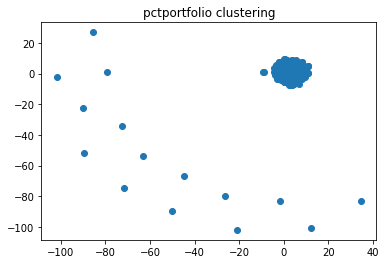

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
x = tsne.fit_transform(X)
plt.scatter(x[:,0],x[:,1])
plt.title('pctportfolio clustering')

In [ ]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans

km = TimeSeriesKMeans(n_clusters=9, metric="dtw", max_iter=100, random_state=0).fit(X)
cluster_list = km.predict(X)
print(cluster_list)

[8 0 8 0 8 8 8 8 8 8 0 8 0 8 8 0 0 0 8 8 0 0 0 0 0 0 8 8 0 5 0 0 0 8 0 0 0
 8 0 0 0 0 0 4 8 8 8 8 0 0 8 8 8 0 0 0 0 0 8 8 0 8 0 0 8 0 0 2 8 0 8 0 8 0
 8 8 8 0 8 8 8 0 8 0 8 8 4 8 8 0 0 0 0 8 8 8 0 8 0 0 0 0 8 0 0 8 8 0 0 0 0
 0 6 0 8 0 0 8 8 7 8 4 4 8 0 0 8 0 0 0 0 0 0 8 0 8 8 0 8 0 0 8 0 8 8 8 0 0
 0 8 0 0 0 8 8 8 0 0 8 0 8 0 0 0 0 8 0 0 8 8 8 3 0 0 8 0 8 8 8 8 0 1 8 0 0
 8 8 0 0 0 8 0 0 0 0 0 0 0 8 8 8 8 8 8 0 0 0 8 8 0 0 8 0 0 0 8 0 0 8 8 0 8
 8 0 8 4 0 8 8]


In [ ]:
df_cluster_result = pd.DataFrame({
    'LGCYINVESTORID': investor_ID_list,
    'cluster': cluster_list
})
df_cluster_result = pd.merge(df_cluster_result, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', on='LGCYINVESTORID')
df_cluster_result = df_cluster_result.drop_duplicates(subset='LGCYINVESTORID')
print(df_cluster_result)

        LGCYINVESTORID  cluster                                      FULLNAME
0              3318171        8          BlueMountain Capital Management, LLC
9124           2005964        0                        Guggenheim Investments
50630         10233291        8                  Lighthouse Wealth Management
51004          2005645        0                     BlackRock Japan Co., Ltd.
76856          2003177        8              RBC Global Asset Management Inc.
...                ...      ...                                           ...
3659081        2002582        8               Victory Capital Management Inc.
3694245        5819294        4  TIAA Endowment & Philanthropic Services, LLC
3694367        2412732        0                   AQR Capital Management, LLC
3734554        2006955        8                      Greenlight Capital, Inc.
3735041        2006922        8              Pzena Investment Management, LLC

[229 rows x 3 columns]


In [ ]:
with open('/content/gdrive/My Drive/capstone/full database/kmeans_pct_portfolio.csv', 'w') as f:
  df_cluster_result.to_csv(f)

In [ ]:
# read in investor name and type data
df_investor_type = pd.read_csv('/content/gdrive/My Drive/capstone/full database/investor_name_type.csv')
df_investor_type.head()

,name,type
0,1251 Capital Group,mutual
1,Aegon,mutual
2,Affiliated Managers Group (AMG),mutual
3,AGF Management Limited,mutual
4,AllianceBernstein,mutual


In [ ]:
# !pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import process

# Fuzzy match the investor name in the given list and in the database
def fuzzy_merge(df_1, df_2, key1, key2, threshold=85, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

In [ ]:
df_cluster_result['partial'] = [' '.join(part[0:2]) for part in df_cluster_result['FULLNAME'].astype(str).str.split(' ')]

In [ ]:
df_cluster_result

,LGCYINVESTORID,cluster,FULLNAME,partial
0,3318171,8,"BlueMountain Capital Management, LLC",BlueMountain Capital
9124,2005964,0,Guggenheim Investments,Guggenheim Investments
50630,10233291,8,Lighthouse Wealth Management,Lighthouse Wealth
51004,2005645,0,"BlackRock Japan Co., Ltd.",BlackRock Japan
76856,2003177,8,RBC Global Asset Management Inc.,RBC Global
...,...,...,...,...
3659081,2002582,8,Victory Capital Management Inc.,Victory Capital
3694245,5819294,4,"TIAA Endowment & Philanthropic Services, LLC",TIAA Endowment
3694367,2412732,0,"AQR Capital Management, LLC",AQR Capital
3734554,2006955,8,"Greenlight Capital, Inc.","Greenlight Capital,"


In [ ]:
fuzzy_merge(df_cluster_result, df_investor_type, 'partial', 'name')

,LGCYINVESTORID,cluster,FULLNAME,partial,matches
0,3318171,8,"BlueMountain Capital Management, LLC",BlueMountain Capital,BlueMountain Capital Management
9124,2005964,0,Guggenheim Investments,Guggenheim Investments,
50630,10233291,8,Lighthouse Wealth Management,Lighthouse Wealth,Lighthouse Investment Partners
51004,2005645,0,"BlackRock Japan Co., Ltd.",BlackRock Japan,BlackRock
76856,2003177,8,RBC Global Asset Management Inc.,RBC Global,RBC Global Wealth (CAN)
...,...,...,...,...,...
3659081,2002582,8,Victory Capital Management Inc.,Victory Capital,Victory Capital
3694245,5819294,4,"TIAA Endowment & Philanthropic Services, LLC",TIAA Endowment,
3694367,2412732,0,"AQR Capital Management, LLC",AQR Capital,AQR Capital Management
3734554,2006955,8,"Greenlight Capital, Inc.","Greenlight Capital,",Causeway Capital Management


In [ ]:
df_cluster_result_label = pd.merge(df_cluster_result, df_investor_type, 'left', left_on= 'matches', right_on='name')
print(df_cluster_result_label.head())
with open('/content/gdrive/My Drive/capstone/full database/kmeans_pct_portfolio.csv', 'w') as f:
  df_cluster_result_label.to_csv(f)

  LGCYINVESTORID  cluster  ...                              name    type
0        3318171        8  ...   BlueMountain Capital Management   hedge
1        2005964        0  ...                               NaN     NaN
2       10233291        8  ...    Lighthouse Investment Partners   hedge
3        2005645        0  ...                         BlackRock   hedge
4        2003177        8  ...           RBC Global Wealth (CAN)  mutual

[5 rows x 7 columns]


In [ ]:
km.cluster_centers_

array([[[4.33449353e-08, 1.17579495e-08, 4.24803887e-08, ...,
         0.00000000e+00, 2.49440159e-06, 3.63282830e-08],
        [4.45176707e-08, 0.00000000e+00, 3.38589488e-08, ...,
         0.00000000e+00, 2.88558154e-06, 3.35607420e-08],
        [4.13882655e-08, 0.00000000e+00, 3.56600157e-08, ...,
         0.00000000e+00, 2.65493479e-06, 3.87725351e-08],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.51710999e-13, 6.35408251e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.92213990e-10, 3.33478499e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.42756288e-05, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

## Apply TF.IDF
**Representation:**

| Original TF.IDF | Our usage   |
|------|------|
|   Term  | Instrument| 
|   Document  | Investor_Holddate| 
|   Document containing a list of terms  | Investor_Holddate holding a list of Instrument|   
  
<br>

**Calculation (For each instrument):**

| Symbol | Formula   | In our case|
|------|------| ------|
|   TF (Term Frequency in a doc)  | (count of term in the document) / (total number of words in the document)|  pct values in the pivot table |
|   DF (Document Frequency)  | number of documents containing the term| number of Investor_Holddate holding this instr|
|   IDF (Inverse Document Frequency, smoothen the value by adding 1) | log\[number of documents/(DF + 1)\]| log\[number of Investor_Holddate /(DF + 1)\]|


In [ ]:
# Calculate DF for each instrument, i.e. number of nonzeros in each column in the pivot table
# save as dict (key: instrument, value: DF)
count_nonzero_per_instr = (inves_instr_pivot != 0).astype(int).sum(axis=0)
dict_DF = count_nonzero_per_instr.to_dict() 

In [ ]:
# Calculate IDF for each instrument
# save as dict (key: instrument, value: IDF)

import numpy as np
total_num_doc = len(inves_instr_pivot)
dict_IDF = {instr: np.log(total_num_doc / (DF+1)) for instr, DF in dict_DF.items()}

In [ ]:
# sanity check
print(dict_IDF['8589985230'] == np.log( 3689 / (1+dict_DF['8589985230'])))
print(len(inves_instr_pivot.loc[inves_instr_pivot['15628406408']!=0,'15628406408']) == dict_DF['15628406408'])

True
True


In [ ]:
# Create DTM (Document-Term-Matrix) weighted by TF.IDF (row: investor, col: instr, val: TF.IDF)
# Note: TF is just the value in the inves_instr_pivot table
DTM = inves_instr_pivot.copy()
for instr, IDF in dict_IDF.items():
  DTM[instr] = DTM[instr].apply(lambda x: x*IDF)

# save DTM to drive
# with open('/content/gdrive/My Drive/capstone/full database/DTM.csv', 'w') as f:
#    DTM.to_csv(f)

In [ ]:
DTM

INSTRID,15628406408,15629460778,15629618230,18040003420,18040079078,18040089300,18040116991,18040118466,18040120213,18040121287,18040122047,18040124039,18040126002,18040126076,18040179474,18040182947,18040183308,18040183439,18040183440,18040183446,18040183654,18040186965,18040187202,18040187215,18040187590,18040187644,18040187651,18040187667,18040187681,18040187682,18040187697,18040187698,18040187916,18040188821,18040188923,18040188965,18040188966,18040188967,18040188984,18040189002,...,8591462353,8591462595,8591464955,8591464982,8591465605,8591466015,8591466241,8591466482,8591466992,8591466993,8591475888,8591475921,8591475928,8591475961,8591475970,8591487018,8591487052,8591487067,8591487222,8591487289,8591487688,8591487691,8591487693,8591487724,8591487726,8591492579,8591492620,8591492945,8591494397,8591494790,8591510596,8591543346,8591543871,8591545167,8591551312,8591570395,8591570398,8591590014,8591690579,8591727303
LGCYINVESTORID_HOLDDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10061989_2016-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2016-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2016-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2017-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10061989_2017-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969058_2019-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003067,0.0,0.0,0.0,0.002888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004777,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000287,0.0,0.0,0.0,0.0,0.0,0.000156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9969058_2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002048,0.0,0.0,0.0,0.001836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004244,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000257,0.0,0.0,0.0,0.0,0.0,0.000151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9969058_2019-12-31,

In [ ]:
#sanity check
DTM['15628406408'] == dict_IDF['15628406408'] * inves_instr_pivot['15628406408']

LGCYINVESTORID_HOLDDATE
10061989_2016-06-30    True
10061989_2016-09-30    True
10061989_2016-12-31    True
10061989_2017-03-31    True
10061989_2017-06-30    True
                       ... 
9969058_2019-06-30     True
9969058_2019-09-30     True
9969058_2019-12-31     True
9969058_2020-03-31     True
9969058_2020-06-30     True
Name: 15628406408, Length: 3689, dtype: bool

## Calculate DTW score between two investor's time-series values

In [ ]:
# !pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw, dtw_path
from tslearn.utils import to_time_series_dataset

# model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
# model.fit(data)


X_bis = to_time_series_dataset([[1, 2, 3, 4], [1, 2, 3],[2, 5, 6, 7, 8, 9]])
km = TimeSeriesKMeans(n_clusters=2, max_iter=5,
                      metric="dtw", random_state=0).fit(X_bis)
X_bis
km.labels_

## Define weighted similarity (distance) between two investors

The distance between inv1 and inv2 is the weighted sum DTW scores of their time-series holdings of all the instruments. The weight of each instrument is its IDF.

i.e. distance(inv1, inv2) = weight_instr1 * DTW_score_instr1 + weight_instr2 * DTW_score_instr2 + ...

- Note: drop the instruments with too low weights to speed up the process of similarity calculating

In [ ]:
weights = list(dict_IDF.values())

np.random.seed(42)
plt.hist(weights, density=False, bins=30)
plt.ylabel('count of instruments')
plt.xlabel('IDF')

drop_instr_list = [instr for (instr, weight) in dict_IDF.items() if weight < 7]
inves_instr_pivot_dropped = inves_instr_pivot.copy().drop(drop_instr_list, axis=1)
inves_instr_pivot_dropped.shape # only 707 instr remained

In [ ]:
def weighted_distance(invID_1, invID_2, dict_IDF = dict_IDF, inves_instr_pivot = inves_instr_pivot_dropped):
  weighted_sum = 0
  # for each instrument, calculate the weighted distance
  for instr in inves_instr_pivot.columns: 
    # only calculate distance if either of the two investors has this instrument
    if (instr in has_instr_dict[invID_1]) or (instr in has_instr_dict[invID_2]):
      weight = dict_IDF[instr]
      # get the time-series holding data of the two investors for this instrument
      ts_inv_1 = inves_instr_pivot.loc[inves_instr_pivot.index.str.contains(invID_1), instr].to_list()
      ts_inv_2 = inves_instr_pivot.loc[inves_instr_pivot.index.str.contains(invID_2), instr].to_list()
      DTW_score = dtw(ts_inv_1, ts_inv_2)
      weighted_score = weight * DTW_score
      weighted_sum += weighted_score
  return weighted_sum

# test
weighted_distance(invID_1 = '10061989', invID_2 = '9969058', dict_IDF = dict_IDF, inves_instr_pivot = inves_instr_pivot_dropped)

In [ ]:
vanguard_id = '2004260'

investor_list = list(set(df_sub.LGCYINVESTORID))
distance_to_vanguard_list = []
for investor in tqdm(investor_list):
  distance_to_vanguard = weighted_distance(investor, vanguard_id, dict_IDF = dict_IDF, inves_instr_pivot = inves_instr_pivot_dropped)
  distance_to_vanguard_list.append(distance_to_vanguard)

distance_to_vanguard_df = pd.DataFrame({
    'investor_id': investor_list,
    'distance_to_vanguard': distance_to_vanguard_list
})

In [ ]:
merged = pd.merge(distance_to_vanguard_df, df_sub[['LGCYINVESTORID','FULLNAME']], 'left', left_on='investor_id', right_on='LGCYINVESTORID')
merged = merged.drop_duplicates(subset='LGCYINVESTORID').drop(['investor_id'], axis=1)
# with open('/content/gdrive/My Drive/capstone/full database/portfolio_ts_distance_to_vanguard_df.csv', 'w') as f:
#   merged.to_csv(f)

In [ ]:
merged

In [ ]:
# !pip install tslearn

from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
X = random_walks(n_ts=30, sz=4, d=10000)
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0).fit(X)
print(km.predict(X))
km.cluster_centers_

[2 2 0 2 2 0 1 1 2 2 2 2 0 2 2 2 1 2 1 2 2 0 2 2 0 0 1 1 2 2]


array([[[-0.12980314,  0.04794991, -0.62825409, ...,  0.64162871,
          0.00863544,  0.13473828],
        [-1.12762977, -0.38915933, -0.31630475, ...,  0.25611431,
          0.1885268 ,  0.19285554],
        [-0.49193004, -0.49578938, -0.6683574 , ...,  0.68687372,
          0.01971085,  0.11325277],
        [-0.49206201, -0.79833665, -0.60401471, ...,  0.43238242,
         -0.23876392, -0.01770465]],

       [[-0.16606866, -0.39698699, -0.69170677, ..., -0.89616742,
         -0.53189592,  0.38411207],
        [-0.42291859, -0.58412132, -0.81545378, ..., -1.04324714,
         -0.55326565, -0.37390588],
        [-0.58274483, -0.97889427, -0.44312554, ..., -1.0779456 ,
         -0.20182673, -0.52913139],
        [-0.61154433, -0.31494242, -0.70643247, ..., -0.85288481,
         -0.11728338, -0.87038088]],

       [[ 0.09024626,  0.06155862,  0.30494956, ...,  0.04231673,
         -0.01954343,  0.6014124 ],
        [-0.21824088,  0.45363516, -0.27367873, ..., -0.22370293,
          0.